# Table of Contents
 <p><div class="lev1"><a href="#Import-data"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import data</a></div><div class="lev1"><a href="#Projection"><span class="toc-item-num">2&nbsp;&nbsp;</span>Projection</a></div><div class="lev1"><a href="#Map-of-school-districts"><span class="toc-item-num">3&nbsp;&nbsp;</span>Map of school districts</a></div><div class="lev1"><a href="#Merge-sales-and-parcel-data"><span class="toc-item-num">4&nbsp;&nbsp;</span>Merge sales and parcel data</a></div><div class="lev1"><a href="#Attach-school-district-to-each-sale"><span class="toc-item-num">5&nbsp;&nbsp;</span>Attach school district to each sale</a></div><div class="lev1"><a href="#Borders"><span class="toc-item-num">6&nbsp;&nbsp;</span>Borders</a></div><div class="lev2"><a href="#Example"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Example</a></div><div class="lev2"><a href="#Automate"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Automate</a></div><div class="lev1"><a href="#Export"><span class="toc-item-num">7&nbsp;&nbsp;</span>Export</a></div>

Merge the sales data with the parcel location data to get geocoded sales data, to be used to build our Spatial RDD example.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# plt.rc("figure", autolayout=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import zipfile
plot_dataframe = gpd.plotting.plot_dataframe

In [53]:
import shapely
from shapely.geometry import Point, LineString, MultiLineString, MultiPoint

# Import data

In [5]:
schdistrs=gpd.read_file("national_data/Tiger/tlgdb_2015_a_us_school.gdb/a00000009.gdbtable")

In [6]:
cities=gpd.read_file("national_data/Place_2010Census_DP1/Place_2010Census_DP1.shp").to_crs(schdistrs.crs)

In [7]:
tucons_sales2015=pd.read_csv("Tucson_data/Sale2015.csv")

In [8]:
adparcel=gpd.read_file("Tucson_data/adparcel/adparcel.shp")
adparcel.set_index("PARCEL", inplace=True)

In [10]:
print(adparcel.columns)

Index(['ADDRESS', 'ADPARCEL_', 'ADPARCEL_I', 'ADR_ID', 'AD_STREET',
       'AD_SUFFIX', 'ANGLE', 'AREA', 'CITY_ID', 'CODE', 'DATE_ENTER', 'LAT',
       'LON', 'PERIMETER', 'POLYGONID', 'SCALE', 'SOURCE', 'STATUS', 'STREET',
       'STREET_DIR', 'STREET_IDX', 'STREET_NAM', 'STREET_NO', 'SUFFIX_DIR',
       'TILE_NAME', 'X_HPGN', 'Y_HPGN', 'ZIPCITY', 'ZIPCODE', 'geometry'],
      dtype='object')


# Projection

Ultimately, our Gaussian Process code will need x and y planar coordinates, with which distances between two points can be calculated as $\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$. Therefore we can't use raw longitudes and latitudes, they first need to be projected onto a Euclidian plane. Arizona has its own [coordinate system](https://www.webcms.pima.gov/cms/One.aspx?portalId=169&pageId=28222) that is a good choice for this task, and is associated with the [EPSG code 26749](http://www.spatialreference.org/ref/epsg/26749/). All we need to do is convert the coordinate reference system (CRS) of all our dataframes to EPSG 26749.

In [20]:
adparcel = adparcel.to_crs(epsg=26749)
schdistrs = schdistrs.to_crs(epsg=26749)
cities = cities.to_crs(epsg=26749)

In [15]:
print(adparcel.ix[0, "geometry"])
print(adparcel.ix[1, "geometry"])

POINT (936436.4682794245 553187.1136988925)
POINT (937315.5846172333 552895.5028526088)


Let's take a quick moment to check that the distances returned by the geopandas library can also be obtained via the simple Euclidian distance formula.

In [17]:
adparcel.geometry[0].distance(adparcel.geometry[1])

926.2194238260362

In [18]:
np.sqrt((936436.4682794245-937315.5846172333)**2+(553187.1136988925-552895.5028526088)**2)

926.21942382603618

# Map of school districts

In [97]:
def city_schdistrs(city):
    intersect = schdistrs[schdistrs.intersects(city)]
    areas = intersect.intersection(city).area
    # throw out districts that aren't at least a thousandth of the city's surface area
    nonzero_area = areas > (city.area/1000)
    return intersect[nonzero_area] 
    
def simplename(s):
    return (s
        .replace("District","")
        .replace("School","")
        .replace("Community","")
        .replace("Independent","")
        .replace("Unified","")
        .strip()
    )
def plot_city(city):
    plot_dataframe(city, color="white", linewidth=3)
    old_xlim = plt.xlim()
    old_ylim = plt.ylim()
    schdistrs = city_schdistrs(city.geometry.values[0])
    plot_dataframe(schdistrs, ax=plt.gca())
    plt.xlim(old_xlim[0]-0.1,old_xlim[1]+0.1)
    plt.ylim(old_ylim[0]-0.1,old_ylim[1]+0.1)

    for row in schdistrs.iterrows():
        name = row[1].NAME
        geom = row[1].geometry
        x = geom.centroid.x
        y = geom.centroid.y
        plt.text(np.clip(x,*plt.xlim()), np.clip(y,*plt.ylim()), simplename(name), horizontalalignment='center')

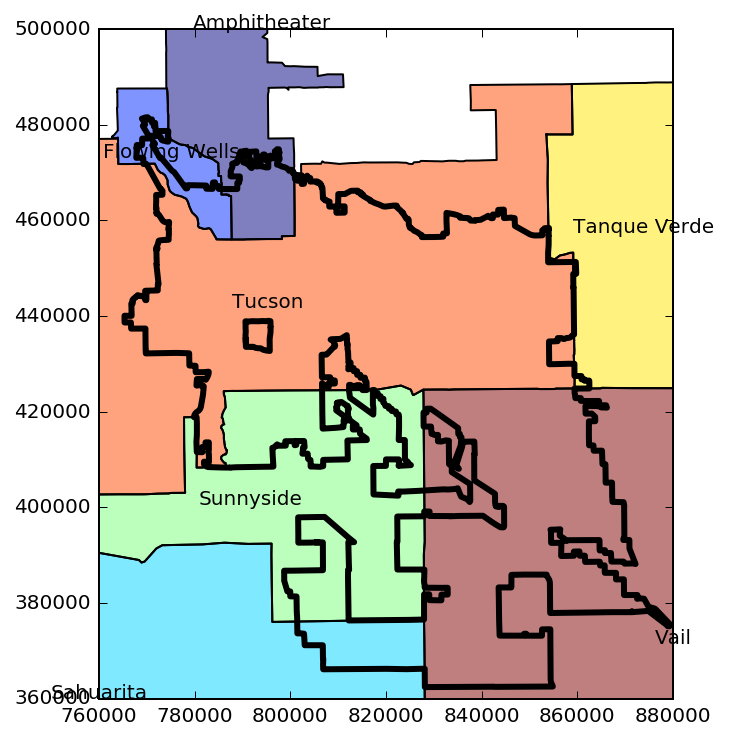

In [98]:
tucson=cities[cities.NAMELSAD10=="Tucson city"].iloc[0:1]
plot_city(tucson)

# Merge sales and parcel data

In [24]:
TC_sales_geocoded=tucons_sales2015.set_index("Parcel")
TC_sales_geocoded=adparcel.join(TC_sales_geocoded, how="right")

In [25]:
notnan = np.logical_not(TC_sales_geocoded.geometry.isnull().values)
TC_sales_notnan = TC_sales_geocoded[notnan]

In [26]:
in_tucson = TC_sales_notnan.within(tucson.geometry.values[0])

In [27]:
TC_sales_Tucson = TC_sales_notnan[in_tucson]
TC_sales_Tucson=TC_sales_Tucson.to_crs(tucson.crs)

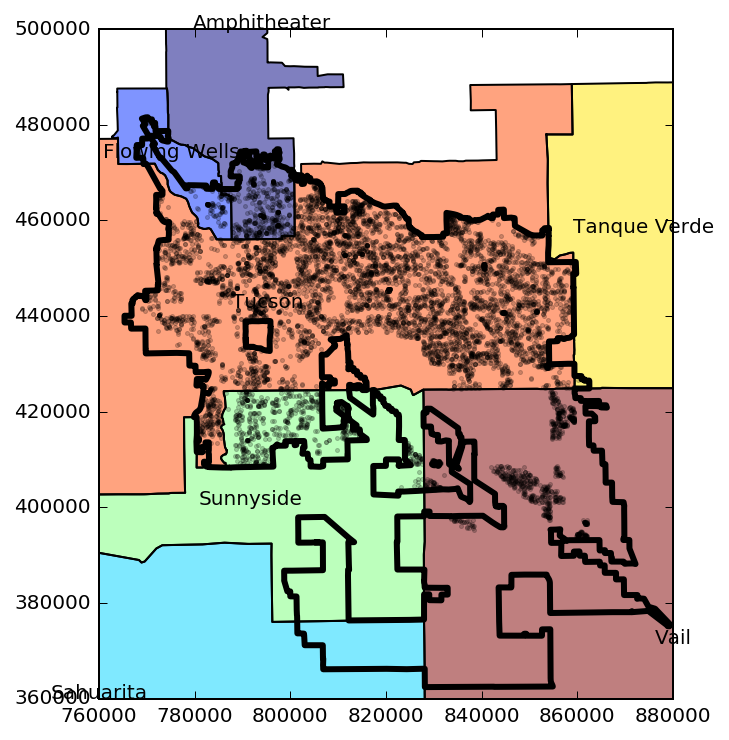

In [99]:
plot_city(tucson)
plot_dataframe(TC_sales_Tucson, ax=plt.gca(), color="black", alpha=0.2)

Each dot represents the sale of a property in 2015. The borders between school districts in the North-West part of the city look particularly promising. The border between Tucson Unified and Sunnyside Unified could also work. The long straight border between Tucson Unified and Vail Unified is unfortunately only populated on one side.

# Attach school district to each sale

In [29]:
tucson_schdistrs=city_schdistrs(tucson.geometry.values[0])
tucson_schdistrs

,ALAND,AWATER,GEOID,HIGRADE,INTPTLAT,INTPTLON,LOGRADE,NAME,SDTYP,geometry
198,2.824679e+08,535621.0,0400680,12,+32.4129772,-110.9635991,PK,Amphitheater Unified District,None,"(POLYGON ((773893.759044982 507678.4718737552,..."
217,3.098886e+07,496444.0,0403010,12,+32.2960635,-111.0258593,PK,Flowing Wells Unified District,None,"(POLYGON ((762769.28299846 477399.3870299263, ..."
263,1.574332e+09,377306.0,0407300,12,+31.8160529,-111.1075526,PK,Sahuarita Unified District,None,(POLYGON ((654819.5630310699 232333.8181122941...
273,2.504837e+08,0.0,0408170,12,+32.0979297,-110.9752480,PK,Sunnyside Unified District,None,(POLYGON ((716785.7785320296 402132.2473556149...
275,2.013622e+08,0.0,0408280,12,+32.2516572,-110.7076014,PK,Tanque Verde Unified District,None,(POLYGON ((853566.3010435958 477957.2288085489...
279,5.920991e+08,755055.0,0408800,12,+32.2114132,-110.9627656,PK,Tucson Unified District,None,"(POLYGON ((732295.8420664769 420816.086226508,..."
280,1.009159e+09,0.0,0408850,12,+32.0155294,-110.6873435,PK,Vail Unified District,None,"(POLYGON ((828027.0972032794 354217.043245537,..."


In [30]:
def get_ind(zones, point):
    ind=np.where(zones.contains(point))[0]
    if len(ind)==0:
        return None
    elif len(ind)>1:
        return None#np.argmin(zones.iloc[ind].area)
    return ind[0]

In [31]:
idistr=[get_ind(tucson_schdistrs, house) for house in TC_sales_Tucson.geometry]

In [32]:
sum([i is None for i in idistr])

0

In [33]:
TC_sales_Tucson["SchDistr"]=tucson_schdistrs.NAME.values[idistr]

# Borders

## Example

In [39]:
d1=tucson_schdistrs.geometry.values[0]
d2=tucson_schdistrs.geometry.values[1]

In [40]:
border=d1.intersection(d2)
assert isinstance(border, MultiLineString)

In [41]:
len(border.geoms)

325

In [42]:
max([l.length for l in border])

1675.6186810104182

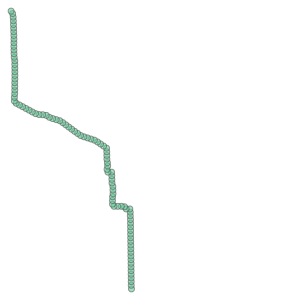

In [56]:
MultiPoint([border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])

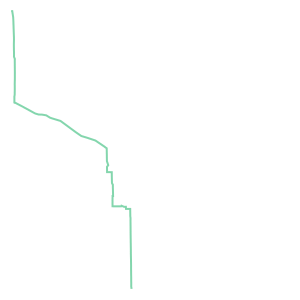

In [50]:
shapely.ops.linemerge(border.geoms)

## Automate

In [63]:
import itertools

In [71]:
ndistr = tucson_schdistrs.shape[0]
distr1_ls=[]
distr2_ls=[]
sentinels_ls=[]
borders_ls=[]

for i,j in itertools.combinations(range(ndistr),2):
    di = tucson_schdistrs.geometry.values[i]
    dj = tucson_schdistrs.geometry.values[j]
    distr_i = tucson_schdistrs.NAME.values[i]
    distr_j = tucson_schdistrs.NAME.values[j]
    border = di.intersection(dj)
    if not border.geoms:
        continue
#     assert isinstance(border, MultiLineString)
    merged_border = shapely.ops.linemerge(border)
    sentinels = MultiPoint([border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])
    sentinels_ls.append(sentinels)
    sentinels_ls.append(sentinels)
    borders_ls.append(merged_border)
    borders_ls.append(merged_border)
    distr1_ls.append(distr_i)
    distr1_ls.append(distr_j)
    distr2_ls.append(distr_j)
    distr2_ls.append(distr_i)

In [72]:
borders = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": borders_ls})
sentinels = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": sentinels_ls})

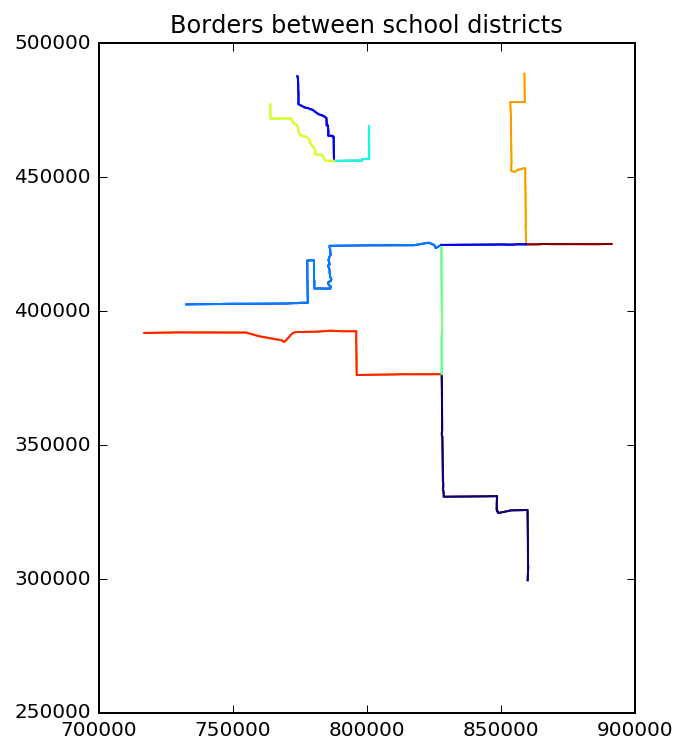

In [73]:
plot_dataframe(borders)
plt.title("Borders between school districts")

# Export

In [94]:
TC_sales_Tucson["X_PRJ"] = [p.x for p in TC_sales_Tucson.geometry.values]
TC_sales_Tucson["Y_PRJ"] = [p.y for p in TC_sales_Tucson.geometry.values]

In [95]:
TC_sales_Tucson.to_csv("Tucson_data/processed/Tucson_sales.csv")

In [75]:
borders.to_file('Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_borders.shp', driver='ESRI Shapefile')

In [76]:
sentinels.to_file('Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.shp', driver='ESRI Shapefile')

In [77]:
with open("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_borders.json", "w") as f:
    f.write(borders.to_json())

In [78]:
with open("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json", "w") as f:
    f.write(sentinels.to_json())